In [13]:
import time      # For the execution time

import numpy as np  # For numerical computations
import pandas as pd # TO deal with tabular data
import matplotlib.pyplot as plt # To visualise data
import seaborn as sns # Make the plots visually appealing

In [14]:
from sklearn.datasets import fetch_california_housing

In [15]:
california = fetch_california_housing() # Loading the dataset

X = california.data # The input/feature variables
y = california.target * 100000 # Target variable scaled

print(f'Data shape: {X.shape}')
print(f'Target shape: {y.shape}')

Data shape: (20640, 8)
Target shape: (20640,)


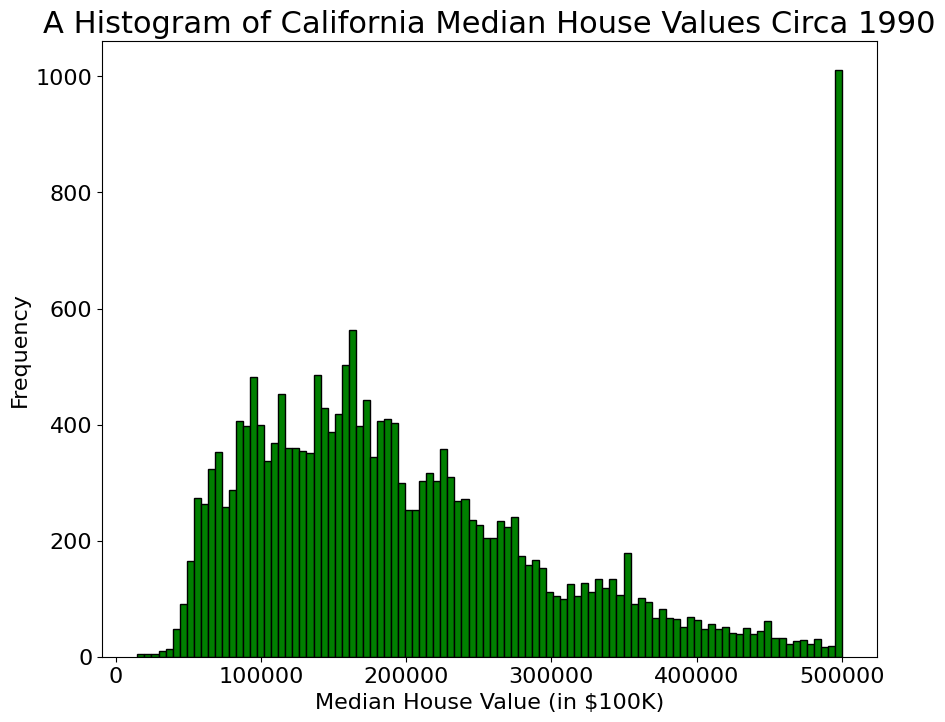

In [16]:
plt.figure(figsize = (10, 8))
plt.hist(y, bins=100, color="green", edgecolor = "black")
plt.xlabel("Median House Value (in $100K)", size=16)
plt.ylabel("Frequency", size=16)
plt.title("A Histogram of California Median House Values Circa 1990", size=22)
plt.xticks(size=16)
plt.yticks(size=16)
plt.show()

In [17]:
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(16512, 8) (16512,)
(4128, 8) (4128,)


In [18]:

# Start timing
start_time = time.time()

# Sit linear regression
my_linear_regression = LinearRegression().fit(X_train,y_train)
y_pred = my_linear_regression.predict(X_test)

end_time = time.time()

# Print point estimates of the coefficients
print(f"beta_intercept: {round(my_linear_regression.intercept_, 2)}")
for i, col in enumerate(california.feature_names):
    print(f"beta_{col}: {round(my_linear_regression.coef_[i], 2)}")

beta_intercept: -3663400.37
beta_MedInc: 44363.55
beta_HouseAge: 945.27
beta_AveRooms: -11205.6
beta_AveBedrms: 66817.59
beta_Population: -0.36
beta_AveOccup: -352.18
beta_Latitude: -41622.99
beta_Longitude: -43018.69


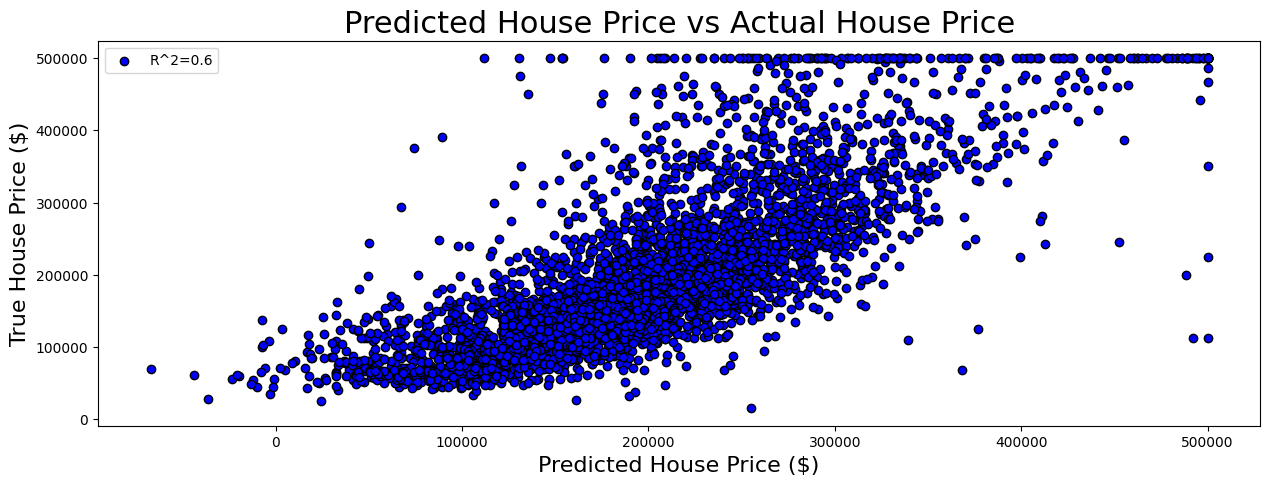

In [19]:

def plot_all_observations(y_true, y_pred, y_max):
    
    y_pred_censored = np.where(y_pred > y_max, y_max, y_pred)
    
    plt.figure(figsize=(15, 5))
    plt.scatter(y_pred_censored, y_test, 
                c="blue", edgecolor="black", 
                label=f'R^2={round(r2_score(y_test, y_pred_censored),2)}')
    
    plt.title("Predicted House Price vs Actual House Price", size=22)
    plt.xlabel("Predicted House Price ($)", size=16)
    plt.ylabel("True House Price ($)", size=16)
    plt.ticklabel_format(style='plain')
    plt.legend()
    
    plt.show()
    
    
    
# Now let's call our function
y_censor_label = y_train.max()
plot_all_observations(y_test, y_pred, y_censor_label)

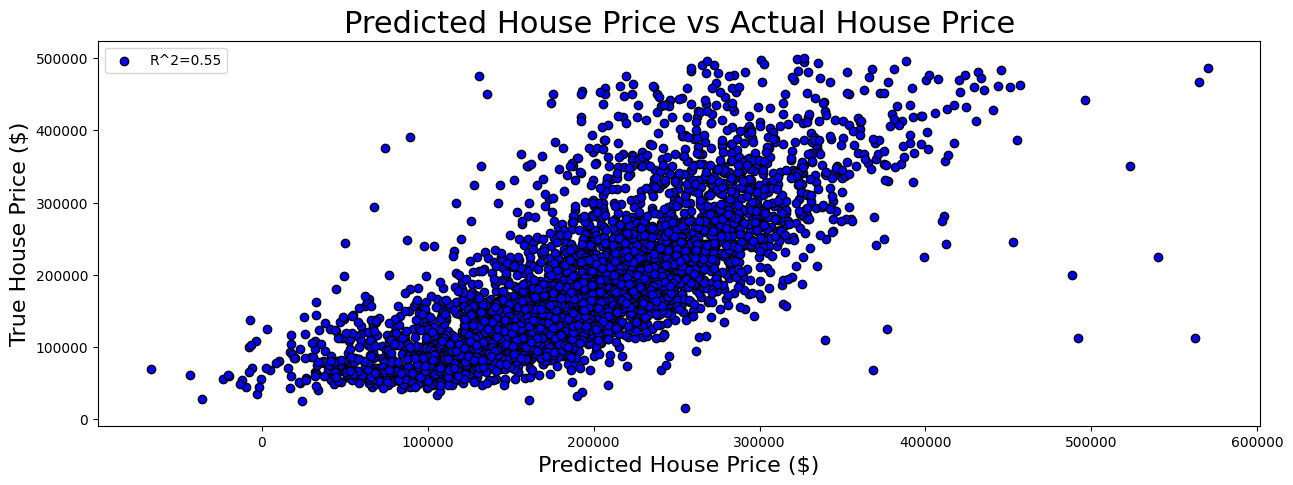

In [20]:

def plot_uncensored_observations(y_true, y_pred, y_censor_label):
    
    y_test_uncensored = y_test[y_test<y_censor_label]
    y_pred_uncensored = y_pred[y_test<y_censor_label]
    
    plt.figure(figsize=(15, 5))
    plt.scatter(y_pred_uncensored, y_test_uncensored, 
                c="blue", edgecolor="black", 
                label=f'R^2={round(r2_score(y_test_uncensored, y_pred_uncensored),2)}')
    
    plt.title("Predicted House Price vs Actual House Price", size=22)
    plt.xlabel("Predicted House Price ($)", size=16)
    plt.ylabel("True House Price ($)", size=16)
    plt.ticklabel_format(style='plain')
    plt.legend()
    
    plt.show()
    
    
    
# Now let's call our function
plot_uncensored_observations(y_test, y_pred, y_censor_label)

In [21]:
# Bayesian Linear Regression

import torch
torch.set_default_tensor_type(torch.FloatTensor)

import pyro
import pyro.distributions as dist

from pyro.infer import MCMC, NUTS

In [22]:
def model_normal(X, y, column_names):

    # Defining intercept priors
    intercept_prior = dist.Normal(0.0, 1.0)
    linear_combination = pyro.sample(f"beta_intercept", intercept_prior)

    # Defining the coefficients priors
    for i in range(X.shape[1]):
        coefficient_prior = dist.Normal(0.0, 1.0)
        beta_coeff = pyro.sample(f'beta_{column_names[i]}', coefficient_prior)
        linear_combination = linear_combination + (X[:, 1] * beta_coeff)

    # Define a sigma prior for the random error
    sigma = pyro.sample("sigma", dist.HalfNormal(scale=10.0))

    # For a simple linear model, the expected mean is the linear combination of parameters
    mean = linear_combination

    with pyro.plate("data", y.shape[0]):
        
        # Assume our expected mean comes from a normal distribution with the mean which
        # depends on the linear combination, and a standard deviatin "sigma"
        outcome_dist = dist.Normal(mean, sigma)
        
        # Condition the expected mean on the observed target y
        observation = pyro.sample("obs", outcome_dist, obs=y)

In [23]:
# Lets now use inference

SAMPLE_NUMBER = 500

X_train_torch = torch.tensor(X_train)
y_train_torch = torch.tensor(y_train)

# Clear the parameter storage
pyro.clear_param_store()

In [24]:
# Initialize our No U-Turn Sampler
my_kernel = NUTS(model_normal, 
                 max_tree_depth=7) 

# Employ the sampler in an MCMC sampling 
# algorithm, and sample 3100 samples. 
# Then discard the first 100
my_mcmc1 = MCMC(my_kernel,
                num_samples=SAMPLE_NUMBER,
                warmup_steps=50)


# Let's time our execution as well
start_time = time.time()

# Run the sampler
my_mcmc1.run(X_train_torch, 
             y_train_torch,
             california.feature_names)

end_time = time.time()

print(f'Inference ran for {round((end_time -  start_time)/60.0, 2)} minutes')

Sample: 100%|██████████| 550/550 [19:03,  2.08s/it, step size=2.11e-04, acc. prob=0.928]

Inference ran for 19.06 minutes


In [25]:
beta_df = pd.DataFrame(my_mcmc1.get_samples())
beta_df.head()

,beta_AveBedrms,beta_AveOccup,beta_AveRooms,beta_HouseAge,beta_Latitude,beta_Longitude,beta_MedInc,beta_Population,beta_intercept,sigma
0,2.253571,2.458860,1.779004,-0.483976,0.136999,0.156056,-1.223319,0.307578,-1.668208,17440.150454
1,2.253104,2.457794,1.781084,-0.479228,0.137537,0.156065,-1.221253,0.308414,-1.668467,17434.415578
2,2.255858,2.456870,1.782684,-0.481041,0.137987,0.157474,-1.220654,0.307996,-1.668730,17433.118803
3,2.254202,2.456418,1.784532,-0.478854,0.135665,0.156812,-1.219241,0.306997,-1.669029,17434.366364
4,2.253260,2.454981,1.785607,-0.477868,0.138217,0.158495,-1.216549,0.307706,-1.669318,17434.369093


In [26]:
def predict_linear_combination(beta_df, X):
    
    coefficients = beta_df.iloc[:, :-1].mean()

    # Find our linear combination again
    linear_combination = X.dot(coefficients[1:]) + coefficients.iloc[0]
    
    return linear_combination

In [27]:

linear_combination = predict_linear_combination(beta_df, X_test)
y_pred = linear_combination

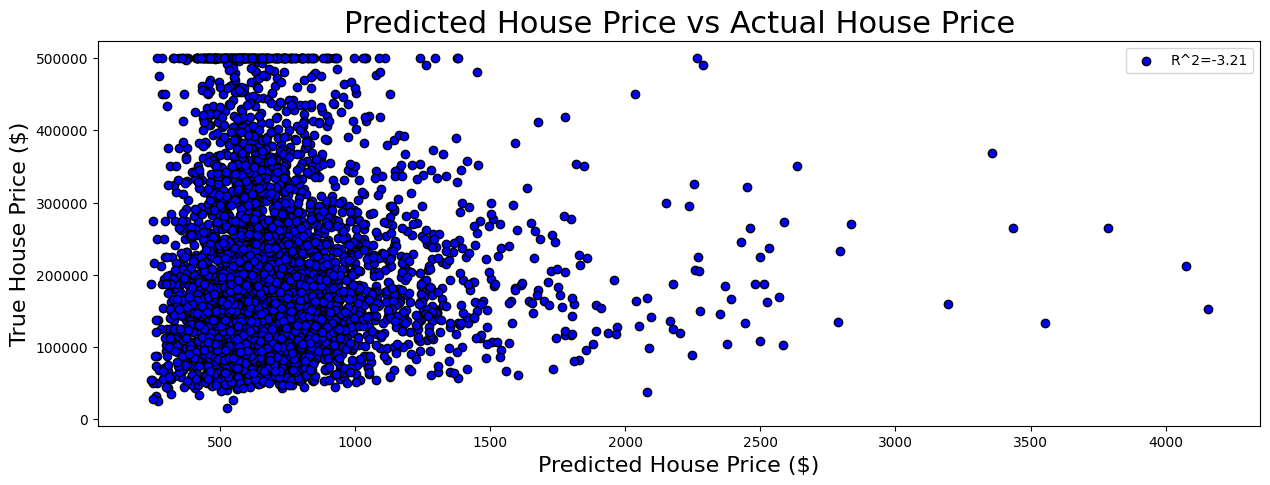

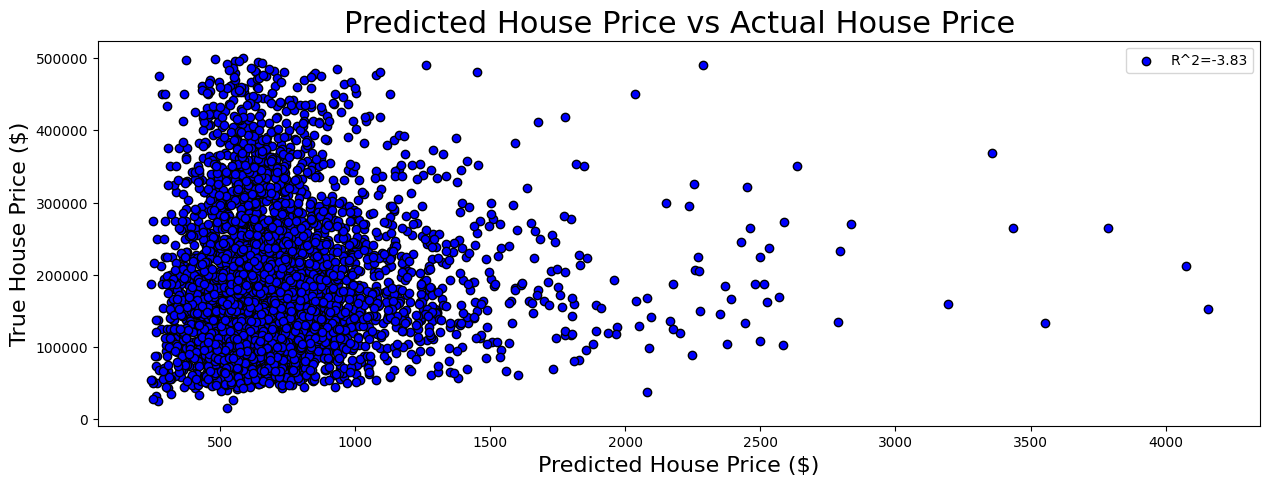

In [28]:
plot_all_observations(y_test, y_pred, y_censor_label)
plot_uncensored_observations(y_test, y_pred, y_censor_label)

C:\Users\sharv\AppData\Local\Temp\ipykernel_24164\2364338415.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(beta_df[key],
C:\Users\sharv\AppData\Local\Temp\ipykernel_24164\2364338415.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(beta_df[key],
C:\Users\sharv\AppData\Local\Temp\ipykerne

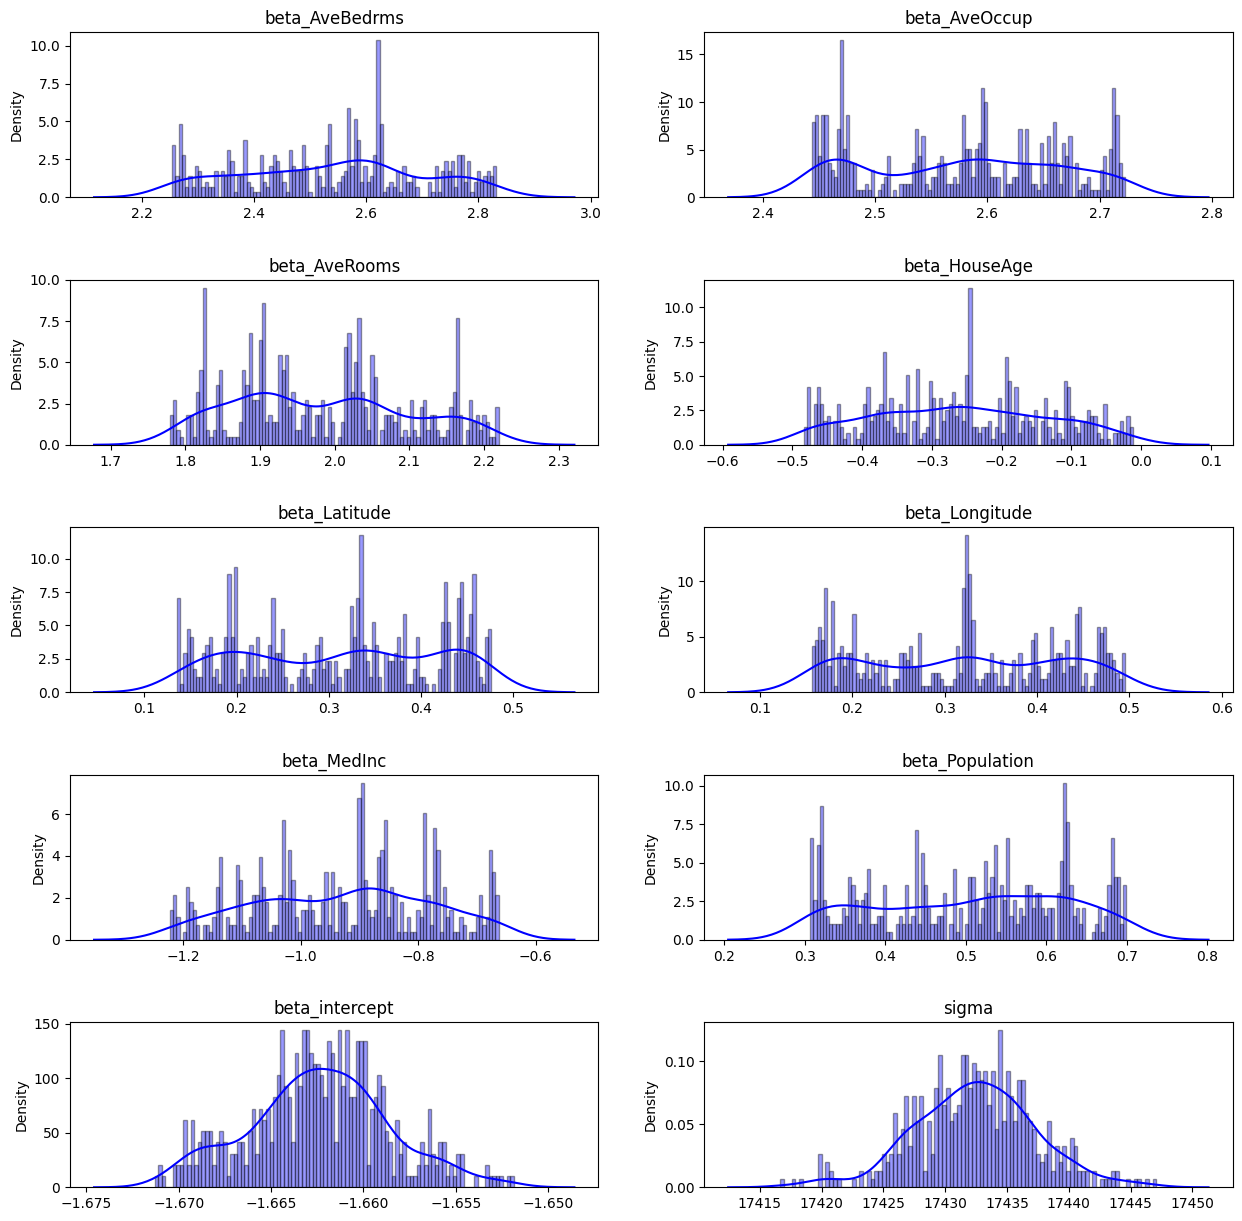

In [29]:
def draw_coefficients(beta_df):
    figure, axis = plt.subplots(5,2, figsize=(15,15))


    for key, ax in zip(beta_df.columns, axis.ravel()):
        ax.set_title(key)
        sns.distplot(beta_df[key], 
                     ax=ax, 
                     bins=100, 
                     color="blue", 
                     kde=True, 
                     axlabel=False, 
                     hist_kws=dict(edgecolor="black"))

    plt.subplots_adjust(hspace=0.5)
    plt.show()
    
draw_coefficients(beta_df)

In [30]:

from sklearn.preprocessing import StandardScaler


# Scale X
my_x_scaler = StandardScaler()
X_train_scaled = my_x_scaler.fit_transform(X_train)

# Scale y
y_censor_label = y_train.max()
y_train_scaled = y_train/y_censor_label

In [31]:
# Convert our data into pytorch tensors
X_train_torch = torch.tensor(X_train_scaled)
y_train_torch = torch.tensor(y_train_scaled)


# Clear previous parameters
pyro.clear_param_store()

# Perform inference again
my_kernel2 = NUTS(model_normal, max_tree_depth=7)

my_mcmc2 = MCMC(my_kernel2,
                num_samples=SAMPLE_NUMBER,
                warmup_steps=100)


start_time = time.time()
my_mcmc2.run(X_train_torch,
             y_train_torch,
             california.feature_names)
end_time = time.time()

print(f'Inference ran for {round((end_time -  start_time)/60.0, 2)} minutes')

Sample: 100%|██████████| 600/600 [30:49,  3.08s/it, step size=3.52e-03, acc. prob=0.957] 

Inference ran for 30.83 minutes


In [32]:
def create_beta_df(beta_df, x_scaler, feature_names):        
    
    i = 0
    # for each column except the intercept and the additional sigma term
    for col in beta_df:
        if (col != 'beta_intercept'):
            if ('beta_' in col):

                # subtract the appropriate value from the intercept (review intercept final expression)
                beta_df['beta_intercept'] -= (beta_df[col] * x_scaler.mean_[i])/x_scaler.scale_[i]     
                
                # scale the coefficient (review each coefficient final expression)
                beta_df[col] /= x_scaler.scale_[i]
                i += 1

    return beta_df

In [33]:
beta2_df = pd.DataFrame(my_mcmc2.get_samples())
beta2_df = create_beta_df(beta2_df, my_x_scaler, california.feature_names)

beta2_df *= y_censor_label

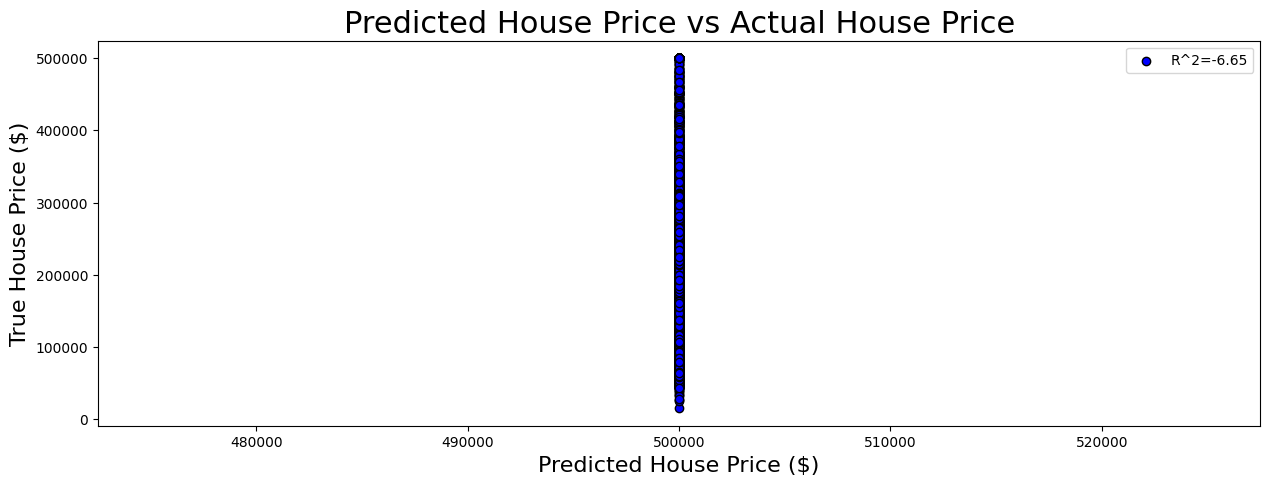

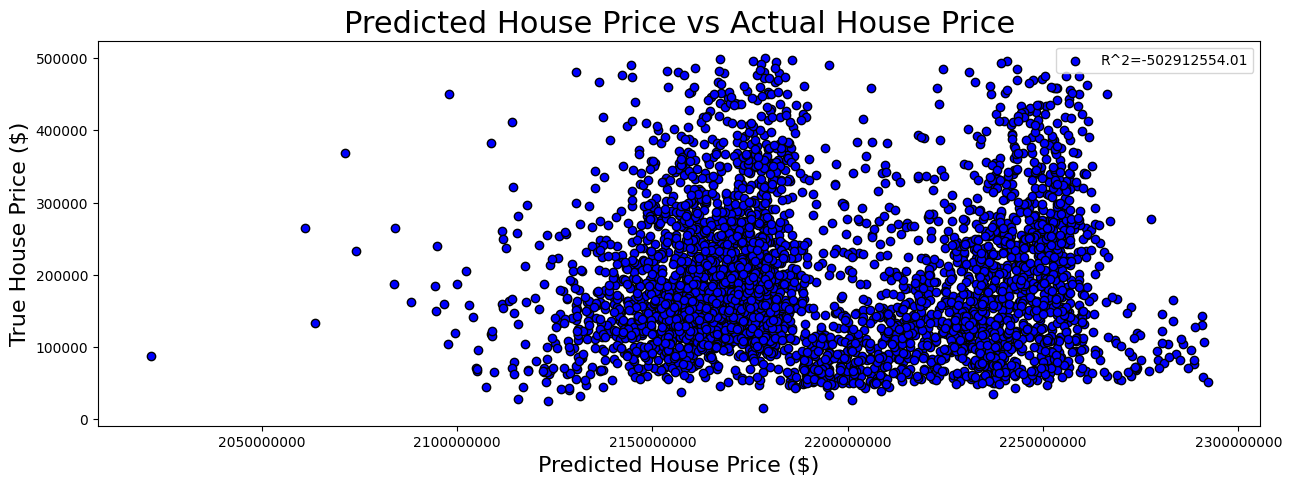

C:\Users\sharv\AppData\Local\Temp\ipykernel_24164\2364338415.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(beta_df[key],
C:\Users\sharv\AppData\Local\Temp\ipykernel_24164\2364338415.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(beta_df[key],
C:\Users\sharv\AppData\Local\Temp\ipykerne

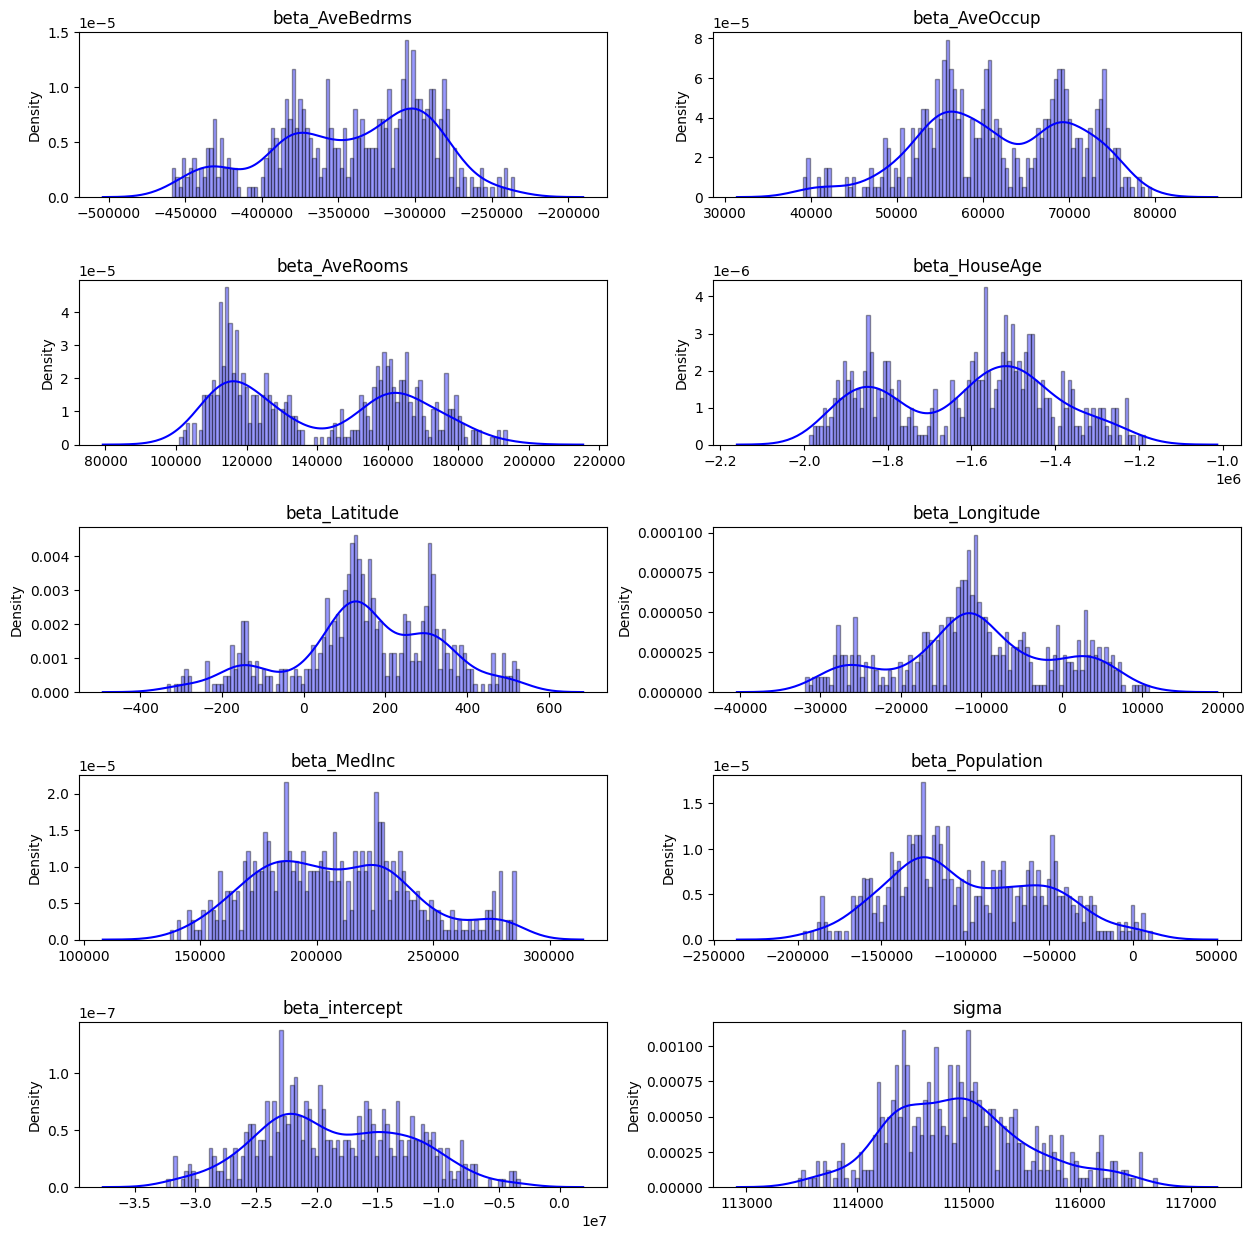

In [34]:
linear_combination = predict_linear_combination(beta2_df, X_test)

y_pred = linear_combination

plot_all_observations(y_test, y_pred, y_censor_label)
plot_uncensored_observations(y_test, y_pred, y_censor_label)

draw_coefficients(beta2_df)

In [35]:
# Using gamma instead of Normal

def model_gamma(X, y, column_names):
    pyro.enable_validation(True)
    
    min_value = torch.finfo(X.dtype).eps
    max_value = torch.finfo(X.dtype).max
    
    # We still need to calculate our linear combination
    
    intercept_prior = dist.Normal(0.0, 1.0)
    linear_combination = pyro.sample(f"beta_intercept", intercept_prior)
    
    
    # Also define coefficient priors
    for i in range(X.shape[1]):
        coefficient_prior = dist.Normal(0.0, 1.0)
        beta_coef = pyro.sample(f"beta_{column_names[i]}", coefficient_prior)
        
        linear_combination = linear_combination + (X[:, i] * beta_coef)
    
        
    # But now our mean will be e^{linear combination}    
    mean = torch.exp(linear_combination).clamp(min=min_value, max=max_value)
    
    # We will also define a rate parameter
    rate = pyro.sample("rate", dist.HalfNormal(scale=10.0)).clamp(min=min_value)
    
    # Since mean = shape/rate, then the shape = mean * rate
    shape = (mean * rate)
    
    
    
    # Now that we have the shape and rate parameters for the
    # Gamma distribution, we can draw samples from it and condition
    # them on our observations
    with pyro.plate("data", y.shape[0]):
        
        outcome_dist = dist.Gamma(shape, rate)
        
        observation = pyro.sample("obs", outcome_dist, obs=y)

In [36]:

# Clear all previous runs of pyro
pyro.clear_param_store()

# And again, perform inference
my_kernel3 = NUTS(model_gamma, max_tree_depth=7)


my_mcmc3 = MCMC(my_kernel3,
                num_samples=SAMPLE_NUMBER,
                warmup_steps=100)



start_time = time.time()
my_mcmc3.run(X_train_torch,
             y_train_torch,
             california.feature_names)
end_time = time.time()

print(f'Inference ran for {round((end_time -  start_time)/60.0, 2)} minutes')

Sample: 100%|██████████| 600/600 [16:22,  1.64s/it, step size=1.96e-03, acc. prob=0.920]

Inference ran for 16.38 minutes


In [37]:

beta3_df = pd.DataFrame(my_mcmc3.get_samples())
beta3_df = create_beta_df(beta3_df, my_x_scaler, california.feature_names)

# Notice now we have to use the y_max value slightly differently
beta3_df['beta_intercept'] += np.log(y_censor_label)

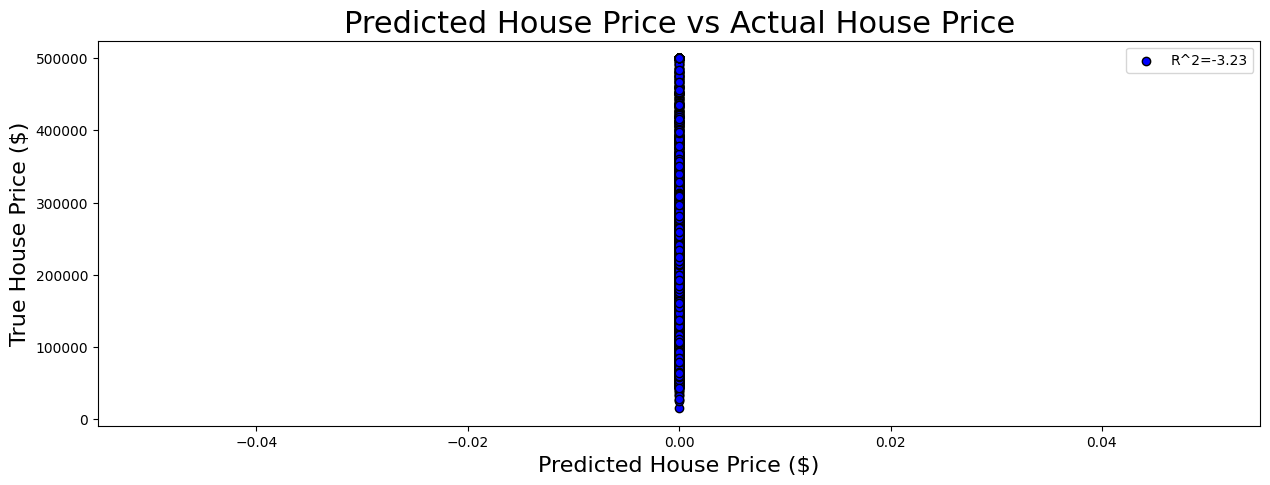

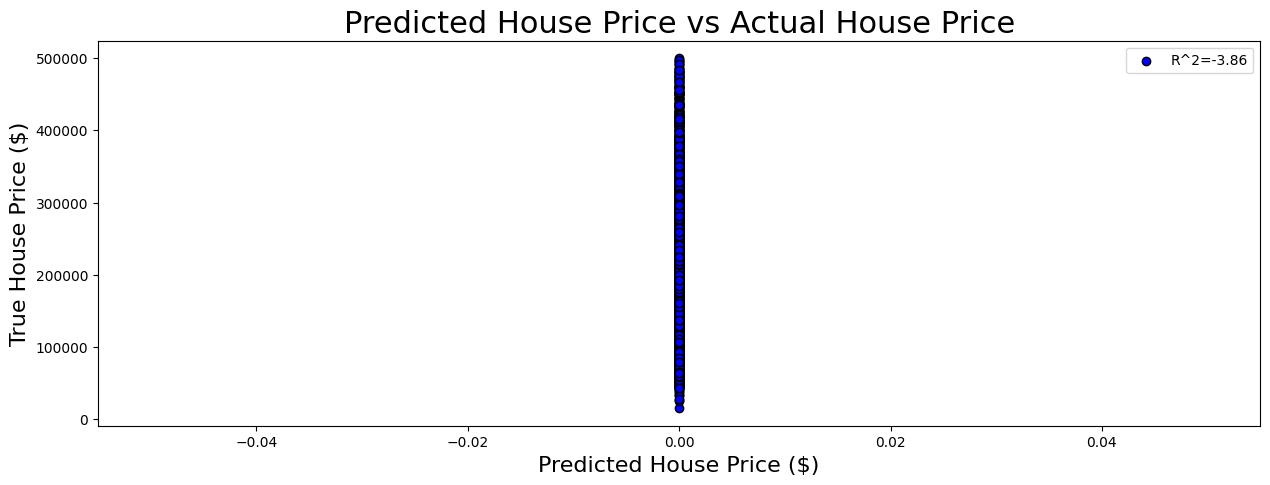

C:\Users\sharv\AppData\Local\Temp\ipykernel_24164\2364338415.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(beta_df[key],
C:\Users\sharv\AppData\Local\Temp\ipykernel_24164\2364338415.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(beta_df[key],
C:\Users\sharv\AppData\Local\Temp\ipykerne

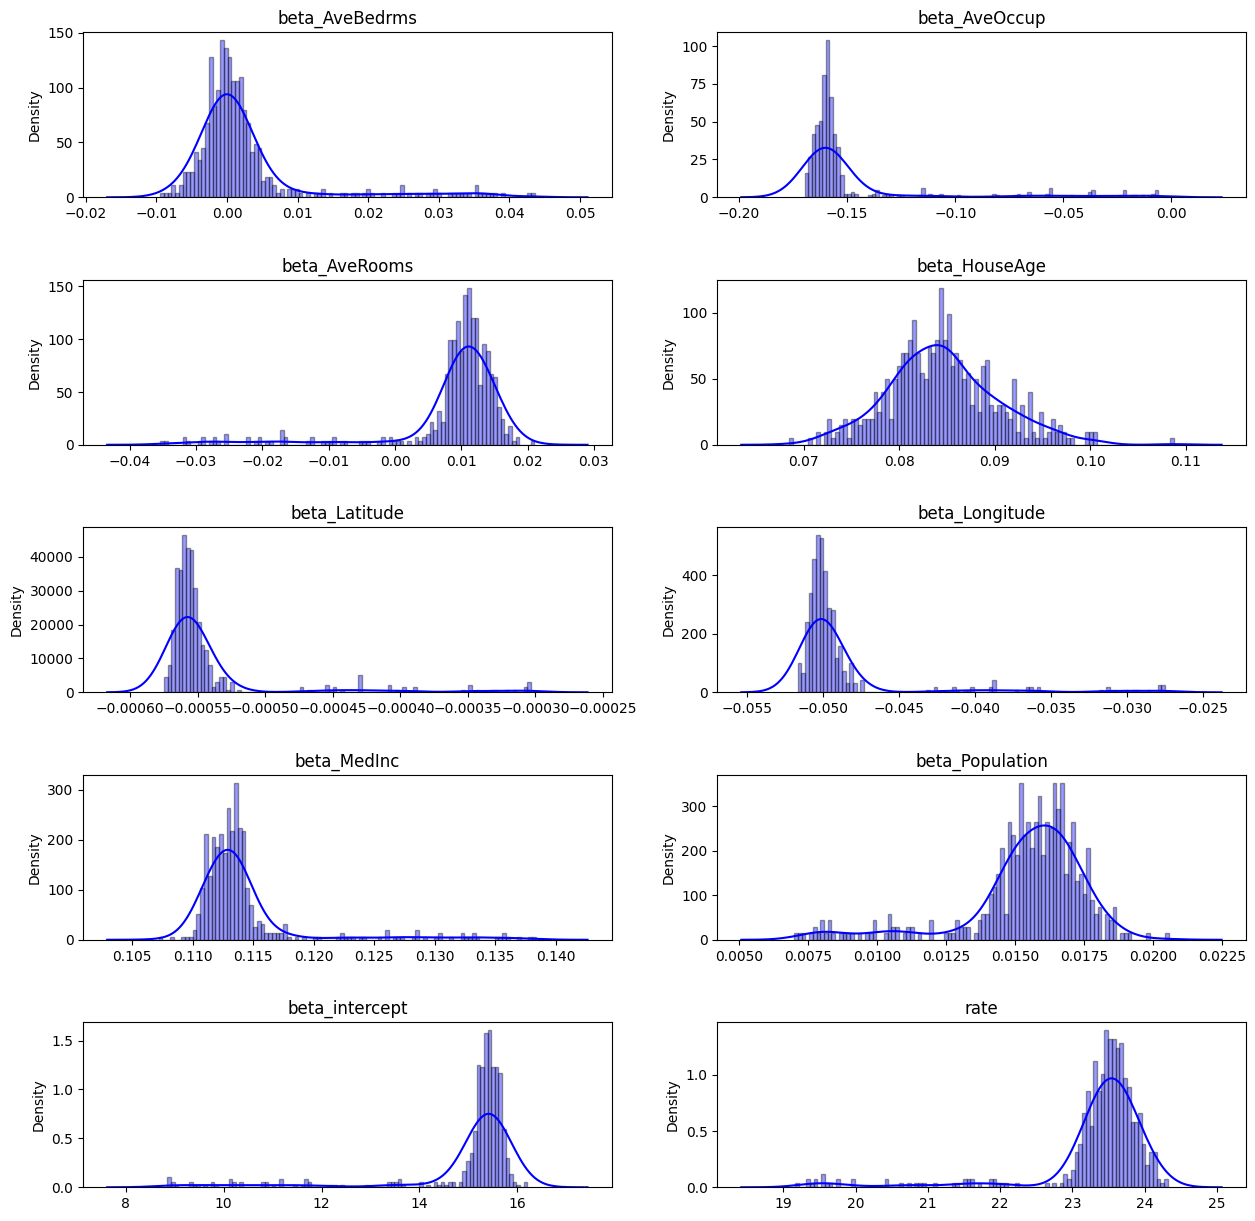

In [38]:

linear_combination = predict_linear_combination(beta3_df, X_test)

# We have to take the EXP of the linear combination now to get the expected values
y_pred = np.exp(linear_combination)

plot_all_observations(y_test, y_pred, y_censor_label)
plot_uncensored_observations(y_test, y_pred, y_censor_label)

draw_coefficients(beta3_df)